## Authenticate to Colab, Drive and GEE

In [ ]:
# !pip install spectral
# from spectral import imshow, view_cube


In [51]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2/'
model_dir = base_dir + 'models/'

sys.path.append(base_dir)

Mounted at /content/gdrive/


## Import Libraries

In [52]:
import tensorflow as tf
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import isfile, join
from pprint import pprint
from collections import OrderedDict
import matplotlib.pyplot as plt
import gdal
import pickle
print(tf.__version__)

2.4.0





# Initialize global variables and functions

In [54]:
# Your Earth Engine username.  This is used to import a classified image
# into your Earth Engine assets folder.
USER_NAME = '2014ee070'

IMAGES_PATH = base_dir + 'Yolo_2016_patch/'
IMAGE_FILE_PREFIX = 'training_2018'

nClasses = 14
landcovers = ["Rice", "Safflower", "Corn", "Other Field crops", "Alfalfa", "Other Pasture", "Cucurbits", "Tomatoes", 
             "Other Truck Crops", "Almonds and pistachios", "Other Deciduous", "Subtropical", "Vineyards", "Other"]
palette = ['#00a8e2', '#d6d600', '#ffd300', '#00ff00', '#ffa5e2', '#e8ffbf', '#ff6666', '#f2a377',
           '#0000ff', '#00a582', '#93cc93', '#ffff7c', '#704489', '#000000']
imageFiles = ['Yolo_2016_patch4.tif']

# Read Tiff

In [55]:
from osgeo import gdal_array
# Read raster data as numeric array from file
filepath1 = IMAGES_PATH+imageFiles[0]
rasterArray1 = gdal_array.LoadFile(filepath1)


In [56]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')
    print(originX, pixelWidth, b, originY, d, pixelHeight)
    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]
    
    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])
    
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    # outband.FlushCache()

In [57]:
print(rasterArray1.shape)
raster_full =  rasterArray1


(118, 248, 342)


In [58]:
raster_full = np.nan_to_num(raster_full)
r = 7
pad = int(r/2)
raster_full = np.pad(raster_full, pad_width = ((0,0),(pad,pad),(pad,pad)), mode = 'edge')
raster_full.shape

(118, 254, 348)

In [59]:
depth, height, width = raster_full.shape[0], raster_full.shape[1], raster_full.shape[2]
print(height, width, depth)

254 348 118


In [60]:
num_bands = 13
feats = []
bands = [0, 1 , 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
time_stamps = 9
for i in range(0, time_stamps):
  for b in bands:
    feats.append(b+i*num_bands)
print(feats)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]


# Load model

In [48]:
# model = tf.keras.models.load_model(model_dir + '/model_convlstm_conv3d_2016_7x7x9x13_13c')
model = tf.keras.models.load_model(model_dir + '/model2_conv2d_2016_7x7x117') # 2D

# model = tf.keras.models.load_model(model_dir + '/model_3d1d_conv3d_2016_7x7x9x13_13c') #90.22

# Making Training and Testing Data

In [64]:
r = 7 # width and height of sample image

d = 1 # pixels to skip for next sample
c = int(r/2) # image center pixel
n_features = len(bands)

preds = []#np.zeros(shape = (height - 6 , width - 6))

for h in range(0, height, d):
  
  row = []
  for w in range(0, width, d):
    img = raster_full[:-1, h:h+r, w:w+r]
    if (img.shape == (depth-1, r, r)) & ~np.isnan(img).any():
      row.append(np.transpose(img,[1,2,0]))
  if len(row) >=1:
    row = np.stack(row)
    prediction = np.argmax(model.predict(row), axis = 1)
    # print(prediction)
    preds.extend(prediction)
    print('row:', h, 'done')



row: 0 done
row: 1 done
row: 2 done
row: 3 done
row: 4 done
row: 5 done
row: 6 done
row: 7 done
row: 8 done
row: 9 done
row: 10 done
row: 11 done
row: 12 done
row: 13 done
row: 14 done
row: 15 done
row: 16 done
row: 17 done
row: 18 done
row: 19 done
row: 20 done
row: 21 done
row: 22 done
row: 23 done
row: 24 done
row: 25 done
row: 26 done
row: 27 done
row: 28 done
row: 29 done
row: 30 done
row: 31 done
row: 32 done
row: 33 done
row: 34 done
row: 35 done
row: 36 done
row: 37 done
row: 38 done
row: 39 done
row: 40 done
row: 41 done
row: 42 done
row: 43 done
row: 44 done
row: 45 done
row: 46 done
row: 47 done
row: 48 done
row: 49 done
row: 50 done
row: 51 done
row: 52 done
row: 53 done
row: 54 done
row: 55 done
row: 56 done
row: 57 done
row: 58 done
row: 59 done
row: 60 done
row: 61 done
row: 62 done
row: 63 done
row: 64 done
row: 65 done
row: 66 done
row: 67 done
row: 68 done
row: 69 done
row: 70 done
row: 71 done
row: 72 done
row: 73 done
row: 74 done
row: 75 done
row: 76 done
row: 77 d

In [50]:
model.predict(raster_full[:-1,100:107, 100:107].T.reshape(-1,7,7,117))

array([[2.5478415e-13, 7.9371922e-23, 3.7193106e-21, 1.0000000e+00,
        5.1687729e-15, 2.6747289e-16, 8.8075476e-16, 9.5166054e-19,
        1.1334865e-21, 1.4983027e-19, 4.2323823e-21, 5.1002874e-27,
        7.1731383e-25, 1.4990442e-14]], dtype=float32)

# Visualize results

In [65]:
from matplotlib import colors

original = raster_full[3:height-3,3:width-3,-1]
cmap = colors.ListedColormap(palette)
# plt.figure(figsize = (height/10,width/10))
# plt.imshow(original, cmap = cmap)
# print(original.shape)

<Figure size 1828.8x2505.6 with 0 Axes>

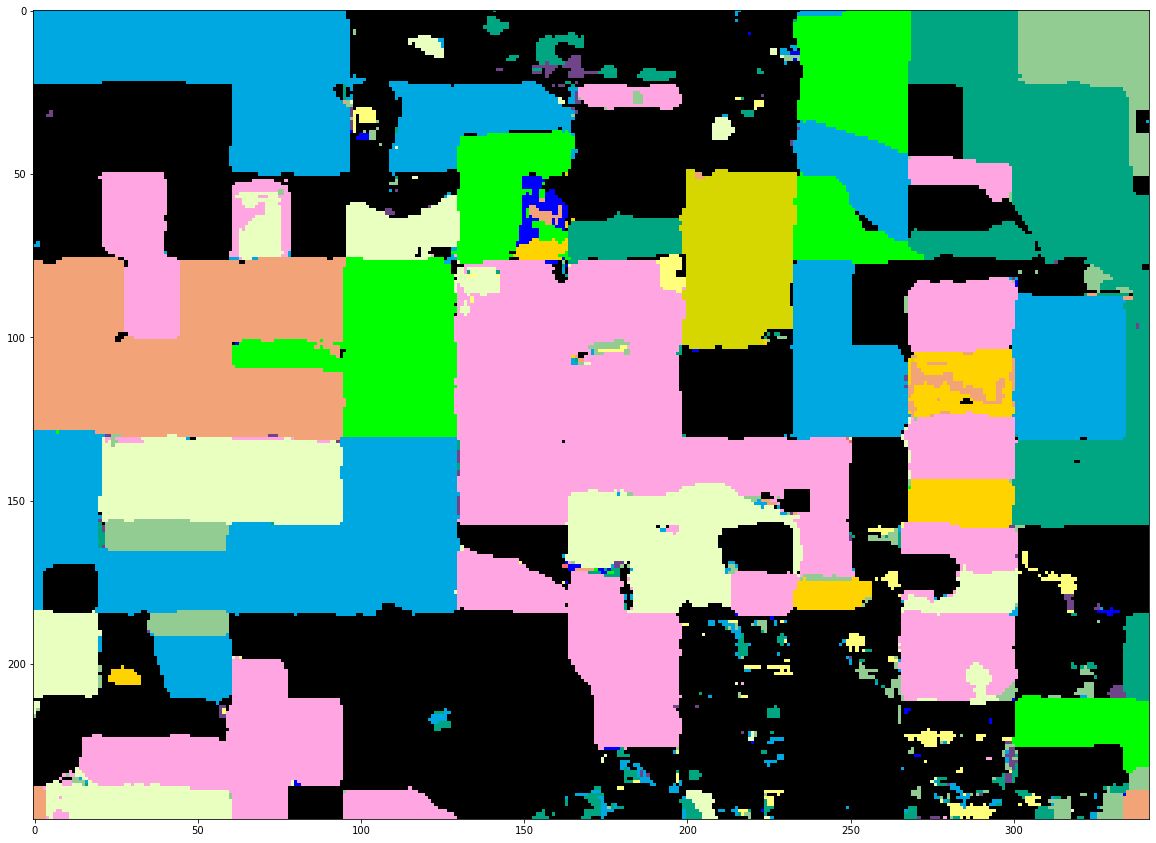

In [66]:
plt.figure(figsize = (height/10,width/10))
plt.figure(figsize = (20,20))

preds = np.array(preds).reshape(height-pad*2, width-pad*2)
plt.imshow(preds, cmap = cmap)

In [67]:
originalTifFile = gdal.Open(filepath1)
array2raster(IMAGES_PATH+"training_conv2d", originalTifFile, np.array(preds), "Float32")

-121.92123682279812 0.00026949458523585647 0.0 38.640403125702335 0.0 -0.00026949458523585647
